# Hyperparameter optimization 


In [113]:
# Install needed packages
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
import plotly.graph_objects as go
import utils
import numpy as np
import matplotlib.pyplot as plt
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time

In [98]:
# Import the data and prepare for further processing
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [99]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()

#rename date and Day_ahead_price columns to ds and y
df = df.rename(columns={'Date': 'ds', 'Day_ahead_price (€/MWh)': 'y'})

In [100]:
def train_test_split_sequential(data, test_size=0.2):
    """
    Split the sequence data into training and testing datasets sequentially.
    
    Parameters:
    - data: List of tuples where each tuple contains (sequence, label).
    - test_size: Fraction of the dataset to be used as test data.

    Returns:
    - train_data: Training data containing sequences and labels.
    - test_data: Testing data containing sequences and labels.
    """
    split_idx = int(len(data) * (1 - test_size))  # Calculate split index
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    return train_data, test_data

train_df, test_df= train_test_split_sequential(df, test_size=0.2)

In [101]:
df

,ds,BEV_vehicles,Biomass (GWh),y,Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),Nuclear_energy (GWh),Oil_price (EUR),Other (GWh),Pumped_storage_generation (GWh),Solar_energy (GWh),Solar_radiation (W/m2),TTF_gas_price (€/MWh),Temperature (°C),Wind_offshore (GWh),Wind_onshore (GWh),Wind_speed (m/s),Net_total_export_import (GWh)
0,2012-01-01,6,98.605,18.19,108.454,51.011,325.337,188.811,250.979,99.64,54.040,19.314,6.263,14.75,21.1000,8.39,3.404,235.467,4.95,54.662
1,2012-01-02,6,98.605,33.82,222.656,51.862,343.168,229.293,258.671,100.04,54.166,28.892,6.312,15.12,20.0000,7.41,3.350,231.772,5.00,-64.477
2,2012-01-03,6,98.605,35.03,162.204,48.851,336.773,241.297,271.495,100.44,53.518,21.072,24.226,31.88,20.9000,5.23,7.292,504.484,7.77,-35.078
3,2012-01-04,6,98.605,32.16,189.633,47.101,323.976,252.289,270.613,103.15,52.194,28.300,14.157,25.21,21.4000,4.78,7.828,541.528,8.04,22.924
4,2012-01-05,6,98.605,20.35,175.733,45.854,327.502,259.018,287.555,103.92,52.179,31.887,4.728,13.46,21.3000,4.23,8.280,572.819,9.98,35.618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,2024-02-25,947,123.683,61.09,48.501,58.671,193.697,255.124,0.000,75.22,60.627,13.565,169.216,97.58,23.7625,4.52,29.879,278.787,3.43,-36.930
4439,2024-02-26,947,124.810,66.27,69.146,58.444,281.177,289.764,0.000,75.09,59.810,12.231,110.504,73.25,23.9000,4.96,62.336,239.555,3.12,-198.686
4440,2024-02-27,947,124.989,73.84,103.379,59.181,351.355,354.042,0.000,76.11,67.170,23.753,85.584,58.12,24.8300,4.53,16.951,131.761,3.11,-209.332
4441,2024-02-28,947,125.068,71.82,93.416,58.160,350.348,338.216,0.000,76.57,65.375,19.042,106.330,66.00,24.8000,3.69,68.585,76.355,2.46,-206.956


In [112]:
import itertools
from tqdm import tqdm
import pandas as pd

# Start the timer
start_time = time.time()

# Define the hyperparameter grid
param_grid = {  
    'changepoint_prior_scale': [0.05, 0.1],
    'seasonality_prior_scale': [5],
    "holidays_prior_scale": [5],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
best_horizon = []  # Initialize best_horizon as a list

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=0.1)

    # Find the index of the minimum value in the 'rmse' column
    min_rmse_index = df_p['rmse'].idxmin()

    # Get the minimum RMSE value
    min_rmse = df_p['rmse'].loc[min_rmse_index]

    # Get the corresponding horizon value
    horizon_day = df_p['horizon'].loc[min_rmse_index]

    # Store the minimum RMSE value and the corresponding horizon
    rmses.append(min_rmse)
    best_horizon.append(horizon_day)

    # Output the results
    print(f"Minimum RMSE: {min_rmse}")
    print(f"Corresponding Horizon: {horizon_day}")

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['horizon'] = best_horizon
print(tuning_results)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")


  0%|          | 0/4 [00:00<?, ?it/s]12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
1

Minimum RMSE: 56.200414373808954
Corresponding Horizon: 49 days 00:00:00


12:15:46 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing
12:15:51 - cmdstanpy - INFO - Chain [1] start processing
12:15:51 - cmdstanpy - INFO - Chain [1

Minimum RMSE: 60.22855933453794
Corresponding Horizon: 60 days 00:00:00


12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:05 - cmdstanpy - INFO - Chain [1

Minimum RMSE: 56.28595181962265
Corresponding Horizon: 49 days 00:00:00


12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1] start processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing
12:16:16 - cmdstanpy - INFO - Chain [1]

Minimum RMSE: 60.67511158773196
Corresponding Horizon: 60 days 00:00:00
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.05                        5                     5   
1                     0.05                        5                     5   
2                     0.10                        5                     5   
3                     0.10                        5                     5   

  seasonality_mode       rmse horizon  
0         additive  56.200414 49 days  
1   multiplicative  60.228559 60 days  
2         additive  56.285952 49 days  
3   multiplicative  60.675112 60 days  
Total execution time: 52.03 seconds


In [114]:
# Define the hyperparameter grid
param_grid = {  
    'changepoint_prior_scale': [0.05, 0.1],
    'seasonality_prior_scale': [5],
    "holidays_prior_scale": [5],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Function to run Prophet with a specific parameter set
def evaluate_params(params):
    try:
        # Fit model with given params
        m = Prophet(**params).fit(df)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
        df_p = performance_metrics(df_cv, rolling_window=0.1)

        # Find the index of the minimum value in the 'rmse' column
        min_rmse_index = df_p['rmse'].idxmin()

        # Get the minimum RMSE value and the corresponding horizon value
        min_rmse = df_p['rmse'].loc[min_rmse_index]
        horizon_day = df_p['horizon'].loc[min_rmse_index]

        return params, min_rmse, horizon_day
    except Exception as e:
        # Handle any exceptions that occur during evaluation
        print(f"Error occurred with parameters {params}: {e}")
        return params, float('inf'), None

# Start the timer
start_time = time.time()

# Use ThreadPoolExecutor to parallelize the evaluation
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(evaluate_params, all_params), total=len(all_params)))

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

# Extract the RMSEs, horizons, and corresponding params
rmses = [result[1] for result in results]
best_horizon = [result[2] for result in results]
tuning_results = pd.DataFrame([result[0] for result in results])
tuning_results['rmse'] = rmses
tuning_results['horizon'] = best_horizon

# Output the tuning results
print(tuning_results)


  0%|          | 0/4 [00:00<?, ?it/s]12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:59 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing


Total execution time: 42.41 seconds
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.05                        5                     5   
1                     0.05                        5                     5   
2                     0.10                        5                     5   
3                     0.10                        5                     5   

  seasonality_mode       rmse horizon  
0         additive  56.200414 49 days  
1   multiplicative  60.228559 60 days  
2         additive  56.285952 49 days  
3   multiplicative  60.675112 60 days  


In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-04-18,33.141842,22.463219,43.726517,28.51,2014-04-17
1,2014-04-19,26.234486,15.508028,36.555463,26.39,2014-04-17
2,2014-04-20,19.771446,9.304920,30.662198,15.16,2014-04-17
3,2014-04-21,31.701947,20.822043,43.080160,21.68,2014-04-17
4,2014-04-22,32.610244,21.432464,44.111650,36.69,2014-04-17
...,...,...,...,...,...,...
6930,2024-02-25,210.515564,169.799624,252.445297,61.09,2023-03-01
6931,2024-02-26,358.489833,316.516579,400.715387,66.27,2023-03-01
6932,2024-02-27,413.022289,369.144582,457.421747,73.84,2023-03-01
6933,2024-02-28,422.127847,377.705391,463.792000,71.82,2023-03-01


In [ ]:
df_cv.cutoff.unique()

array(['2014-04-17T00:00:00.000000000', '2014-10-14T00:00:00.000000000',
       '2015-04-12T00:00:00.000000000', '2015-10-09T00:00:00.000000000',
       '2016-04-06T00:00:00.000000000', '2016-10-03T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2017-09-28T00:00:00.000000000',
       '2018-03-27T00:00:00.000000000', '2018-09-23T00:00:00.000000000',
       '2019-03-22T00:00:00.000000000', '2019-09-18T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-09-12T00:00:00.000000000',
       '2021-03-11T00:00:00.000000000', '2021-09-07T00:00:00.000000000',
       '2022-03-06T00:00:00.000000000', '2022-09-02T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
performance_metrics(df_cv, rolling_window=0.1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4875.676645,69.826046,33.649896,0.564322,0.250240,0.373894,0.558669
1,38 days,4795.068544,69.246433,33.494669,0.566463,0.250251,0.376385,0.555783
2,39 days,4680.513697,68.414280,33.233227,0.566939,0.253907,0.377739,0.554340
3,40 days,4690.438139,68.486773,33.316723,0.574268,0.250240,0.379813,0.552973
4,41 days,4733.355508,68.799386,33.475527,0.576659,0.250251,0.380862,0.552290
...,...,...,...,...,...,...,...,...
324,361 days,24023.736078,154.995923,79.593527,1.258565,0.504165,0.668912,0.320194
325,362 days,24579.989545,156.780067,80.368963,1.255370,0.500546,0.668810,0.321561
326,363 days,25141.056961,158.559317,81.172785,1.244791,0.500546,0.667457,0.325283
327,364 days,25466.882020,159.583464,81.672489,1.235035,0.502593,0.666865,0.328017


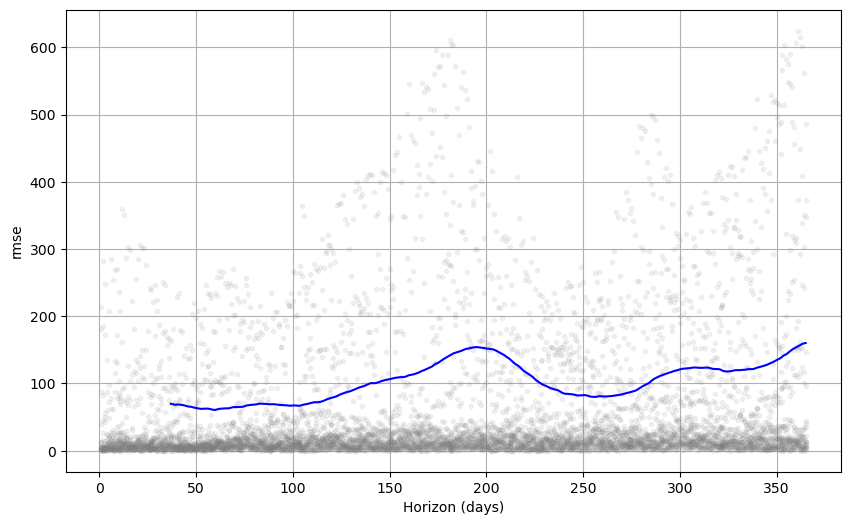

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [ ]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)


{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive'}


In [ ]:
tuning_results.sort_values('rmse', ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,rmse
0,0.05,5,5,additive,56.200414
2,0.10,5,5,additive,56.285952
1,0.05,5,5,multiplicative,60.228559
3,0.10,5,5,multiplicative,60.675112


In [ ]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4875.676645,69.826046,33.649896,0.564322,0.250240,0.373894,0.558669
1,38 days,4795.068544,69.246433,33.494669,0.566463,0.250251,0.376385,0.555783
2,39 days,4680.513697,68.414280,33.233227,0.566939,0.253907,0.377739,0.554340
3,40 days,4690.438139,68.486773,33.316723,0.574268,0.250240,0.379813,0.552973
4,41 days,4733.355508,68.799386,33.475527,0.576659,0.250251,0.380862,0.552290
...,...,...,...,...,...,...,...,...
324,361 days,24023.736078,154.995923,79.593527,1.258565,0.504165,0.668912,0.320194
325,362 days,24579.989545,156.780067,80.368963,1.255370,0.500546,0.668810,0.321561
326,363 days,25141.056961,158.559317,81.172785,1.244791,0.500546,0.667457,0.325283
327,364 days,25466.882020,159.583464,81.672489,1.235035,0.502593,0.666865,0.328017
